We load the bike data again, but we focus on a specific slice to see the daily patterns clearly.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

# Import from our shared utility file
from data import fetch_bike_sharing, fetch_aapl

plt.style.use('seaborn-v0_8')

# Load, fill gaps, and slice the first 6 months of 2011
bike = (
    fetch_bike_sharing()['cnt']
    .asfreq('h')
    .interpolate()
    .loc['2011-01-01':'2011-06-30']
)

We create three powerful plots here:
* Seasonal Plot: Overlays every day on top of each other to show the typical day.
* Subseries Plot: Separates data by day-of-week to contrast Weekday vs. Weekend patterns.
* Lag Plot: Plots t vs t-1 to visualize autocorrelation strength.

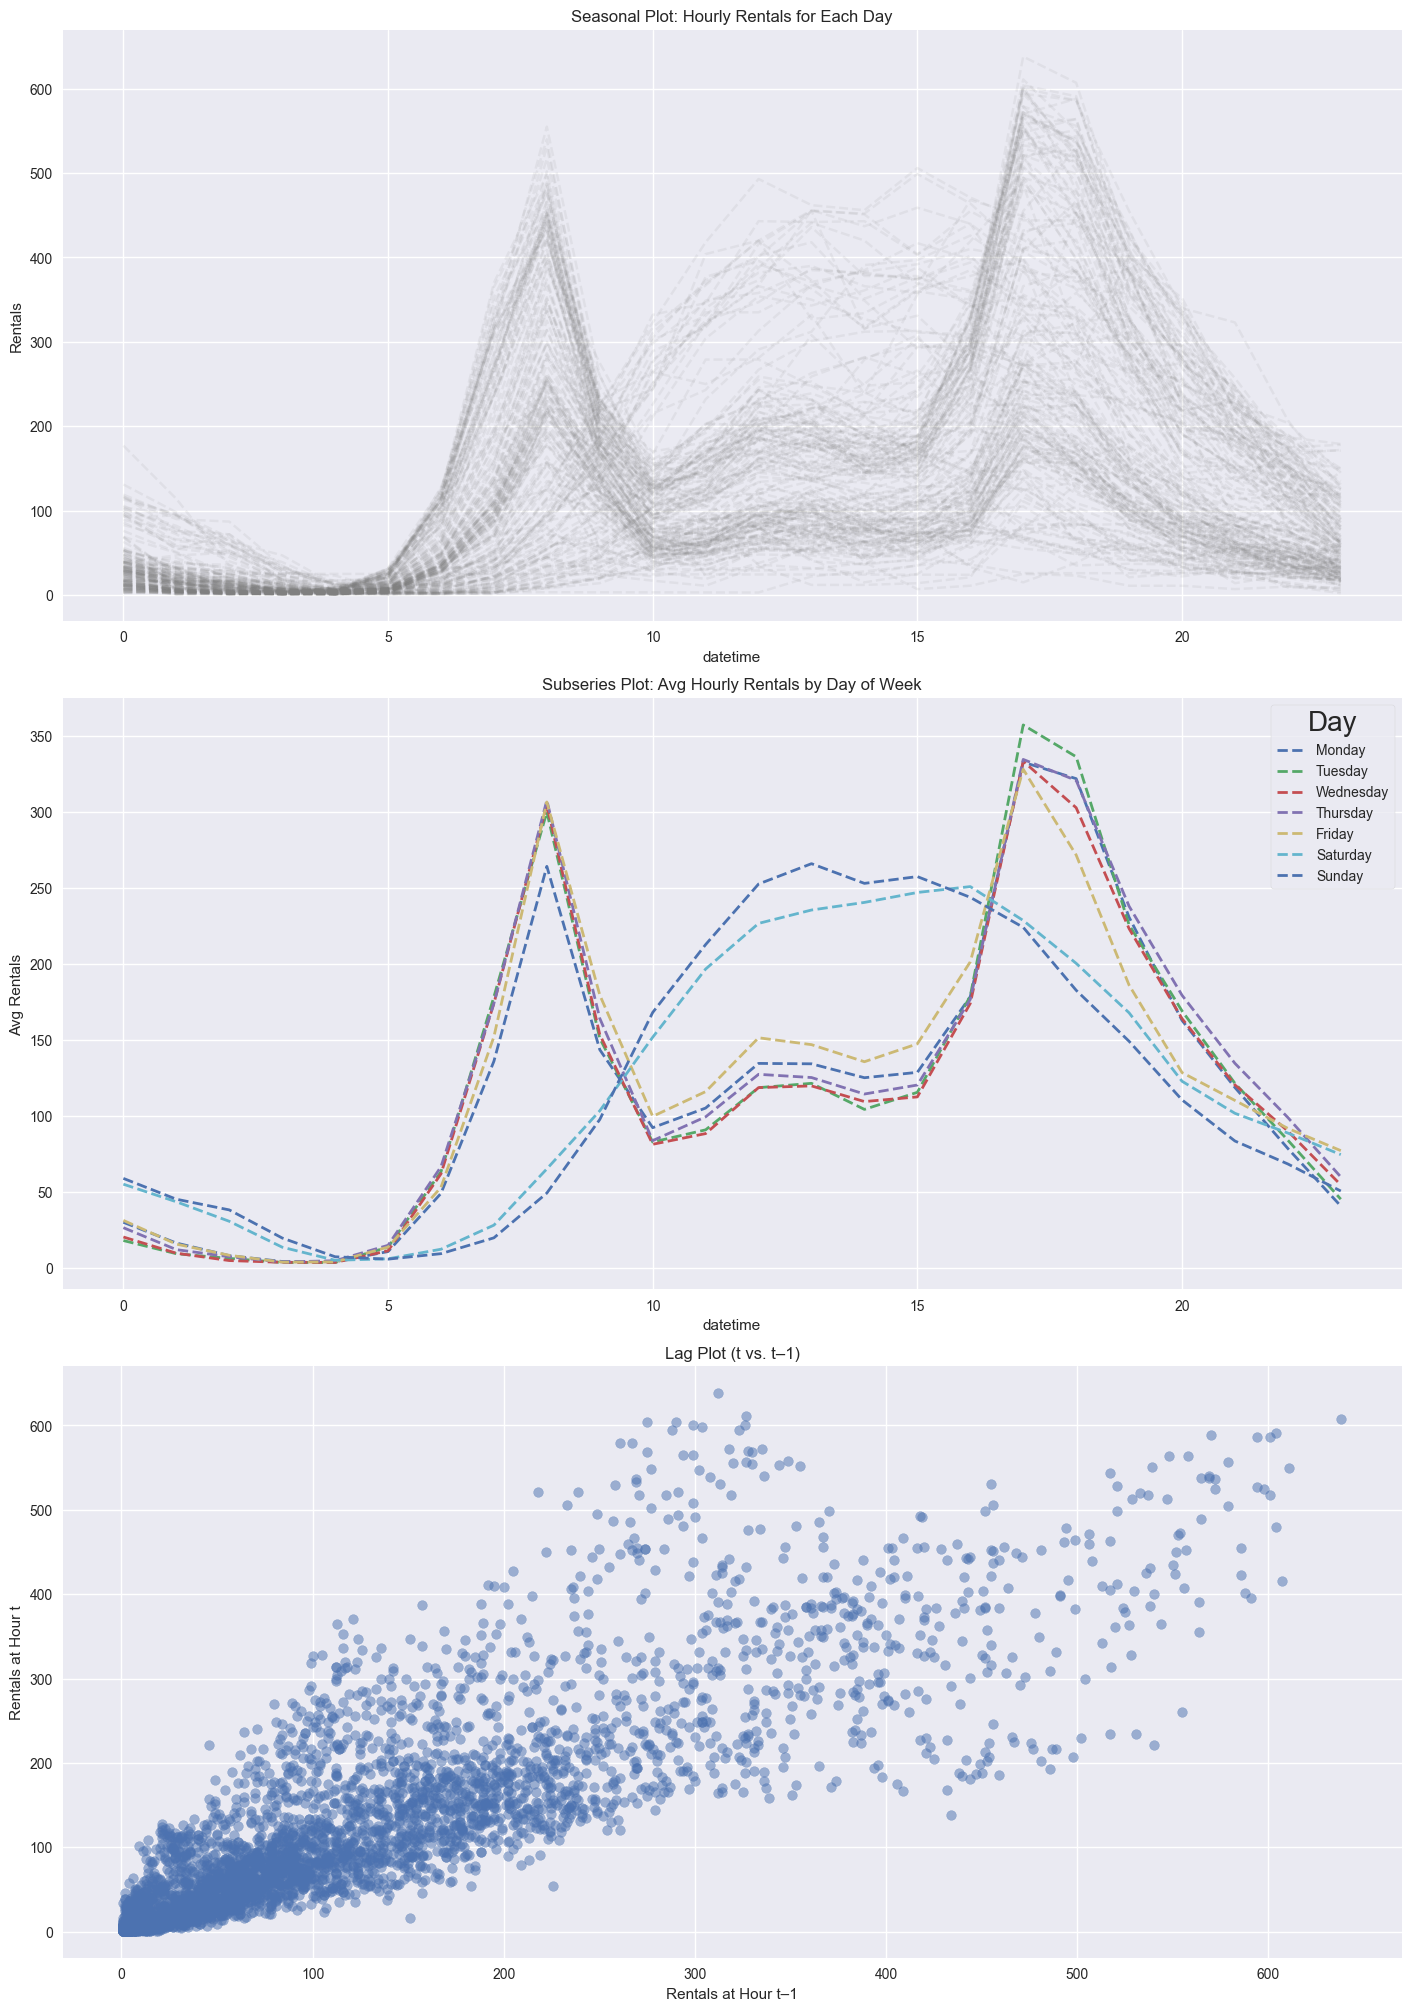

In [7]:
# 1. Prepare the "Seasonal" dataframe (hours x days-of-year)
seasonal = (
    bike
    .groupby([bike.index.hour, bike.index.dayofyear])
    .mean()
    .unstack(level=1)
)

# 2. Prepare the "Subseries" dataframe (hours x day-of-week)
# Reorder to ensure Monday comes first
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
subseries = (
    bike
    .groupby([bike.index.hour, bike.index.day_name()])
    .mean()
    .unstack(level=1)
    .reindex(columns=order)
)

# 3. Create the Grid Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 20), constrained_layout=True)

# Plot 1: Seasonal (Daily Overlays)
seasonal.plot(ax=axes[0], legend=False, alpha=0.1, color='gray') # alpha makes individual lines faint
axes[0].set_title('Seasonal Plot: Hourly Rentals for Each Day')
axes[0].set_ylabel('Rentals')

# Plot 2: Subseries (Day of Week Averages)
subseries.plot(ax=axes[1], linewidth=2)
axes[1].set_title('Subseries Plot: Avg Hourly Rentals by Day of Week')
axes[1].set_ylabel('Avg Rentals')
axes[1].legend(title='Day', loc='upper right', frameon=True)

# Plot 3: Lag Plot (Autocorrelation visual)
lag_plot(bike, lag=1, ax=axes[2], alpha=0.5)
axes[2].set_title('Lag Plot (t vs. t–1)')
axes[2].set_xlabel('Rentals at Hour t–1')
axes[2].set_ylabel('Rentals at Hour t')

plt.show()

A good model should leave no patterns behind. Here, we create a "dummy" model (predicting the daily mean) and check its residuals. The strong pattern remaining in the residuals proves this simple model is inadequate.

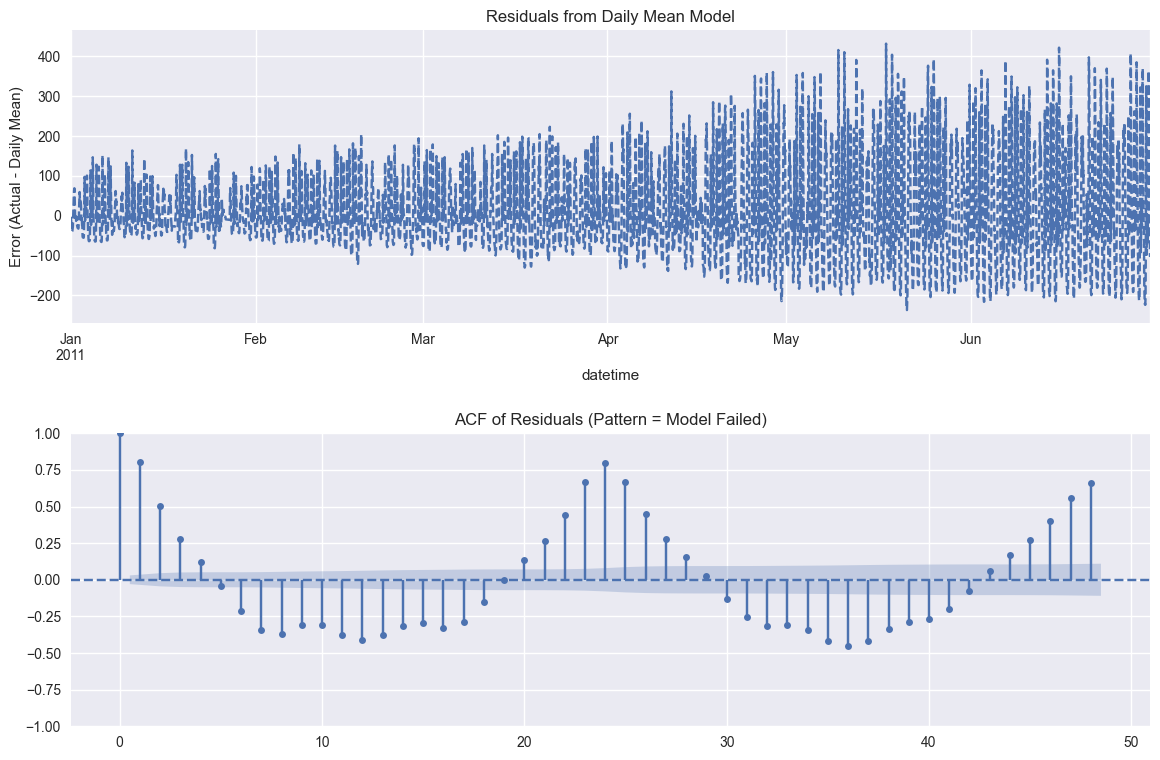

In [8]:
# 1. Create a naive "Dummy" model: Predict the daily average for every hour
# This captures the level of the day, but ignores the hour of the day
daily_mean = bike.groupby(bike.index.date).transform('mean')
residuals = bike - daily_mean

# 2. Plot the Residuals and their Autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Time plot of residuals
residuals.plot(ax=axes[0], title='Residuals from Daily Mean Model')
axes[0].set_ylabel('Error (Actual - Daily Mean)')

# ACF of residuals
# If the model was good, this would look like white noise (no spikes).
# The wavy pattern proves we missed the intraday seasonality.
plot_acf(residuals, lags=48, ax=axes[1], title='ACF of Residuals (Pattern = Model Failed)')

plt.tight_layout()
plt.show()

Before modeling, we check if the series is worth the effort. We compare the Signal-to-Noise (SNR) proxy of the predictable Bike data vs. the noisy Apple stock data.

In [9]:
# Fetch Apple data for comparison
aapl_returns = fetch_aapl()['returns'].dropna()

def calculate_snr_proxy(series):
    """
    A simple proxy for signal-to-noise ratio.
    Compares overall variance (signal) to period-to-period diff variance (noise).
    """
    signal_std = series.std()
    noise_std = series.diff().std()
    
    # Avoid division by zero
    if np.isclose(noise_std, 0):
        return np.inf
        
    return signal_std / noise_std

print("--- Forecastability Analysis (SNR Proxy) ---")
print(f"Bike Rentals SNR: {calculate_snr_proxy(bike):.2f} (High = Predictable)")
print(f"Apple Returns SNR: {calculate_snr_proxy(aapl_returns):.2f} (Low = Noisy)")

/Users/ben/Machine-Learning-for-Time-Series-with-Python-Second-Edition/chapter2/data.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download("AAPL", start="2020-01-01", end="2023-12-31", progress=False)


--- Forecastability Analysis (SNR Proxy) ---
Bike Rentals SNR: 1.84 (High = Predictable)
Apple Returns SNR: 0.66 (Low = Noisy)


Any complex model must beat a simple baseline. We calculate the Mean Absolute Error (MAE) for two baselines:
* Simple Naive: Forecast is yesterday's value.
* Seasonal Naive: Forecast is the value from 24 hours ago.

In [10]:
def get_naive_forecast_mae(series):
    """Forecast(t) = Value(t-1)"""
    y_true = series.iloc[1:]
    y_pred = series.iloc[:-1]
    return mean_absolute_error(y_true, y_pred)

def get_seasonal_naive_mae(series, season_length):
    """Forecast(t) = Value(t - season_length)"""
    y_true = series.iloc[season_length:]
    y_pred = series.iloc[:-season_length]
    return mean_absolute_error(y_true, y_pred)

# Use a clean 1-year slice for benchmarking
bike_2012 = fetch_bike_sharing()['cnt'].asfreq('h').interpolate()['2012']

mae_simple = get_naive_forecast_mae(bike_2012)
mae_seasonal = get_seasonal_naive_mae(bike_2012, season_length=24)

print("--- Baseline Performance (MAE) ---")
print(f"Simple Naive MAE:   {mae_simple:.2f}")
print(f"Seasonal Naive MAE: {mae_seasonal:.2f}")
print(f"Improvement:        {mae_simple - mae_seasonal:.2f} points")
print("\nInsight: The Seasonal Naive model is the real benchmark to beat.")

--- Baseline Performance (MAE) ---
Simple Naive MAE:   79.73
Seasonal Naive MAE: 76.87
Improvement:        2.86 points

Insight: The Seasonal Naive model is the real benchmark to beat.
